# Pairs Trading with State-Space Models

## Replicating Zhang (2021)

This notebook demonstrates the implementation of pairs trading strategies using state-space models, following the methodology in:

> Zhang, G. (2021). Pairs trading with general state space models. *Quantitative Finance*, 21(9), 1567-1587.

### Contents
1. Data Loading and Exploration
2. Spread Computation
3. Model Estimation (MLE)
4. Model Comparison
5. Kalman Filtering
6. Trading Strategies
7. Backtesting
8. Results Visualization

In [6]:
# Setup
import sys
from pathlib import Path

# Add src to path
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    src_path = notebook_dir.parent / "src"
else:
    src_path = notebook_dir / "src"
sys.path.insert(0, str(src_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

%matplotlib inline

print("Setup complete!")
print(f"Source path: {src_path}")

Setup complete!
Source path: /workspaces/Gestion-Quantitative/pairs-ssm/src


## 1. Data Loading

In [9]:
from pairs_ssm import load_pair

# Load PEP-KO pair
data_path = Path("../data/dataGQ.xlsx")
if not data_path.exists():
    data_path = Path("data/dataGQ.xlsx")
    
pair_data = load_pair(str(data_path), "PEP US Equity", "KO US Equity")

# PairData has PA and PB for raw prices
print(f"Date range: {pair_data.PA.index[0]} to {pair_data.PA.index[-1]}")
print(f"Observations: {len(pair_data.PA)}")

Date range: 2000-01-03 00:00:00 to 2025-12-31 00:00:00
Observations: 6539


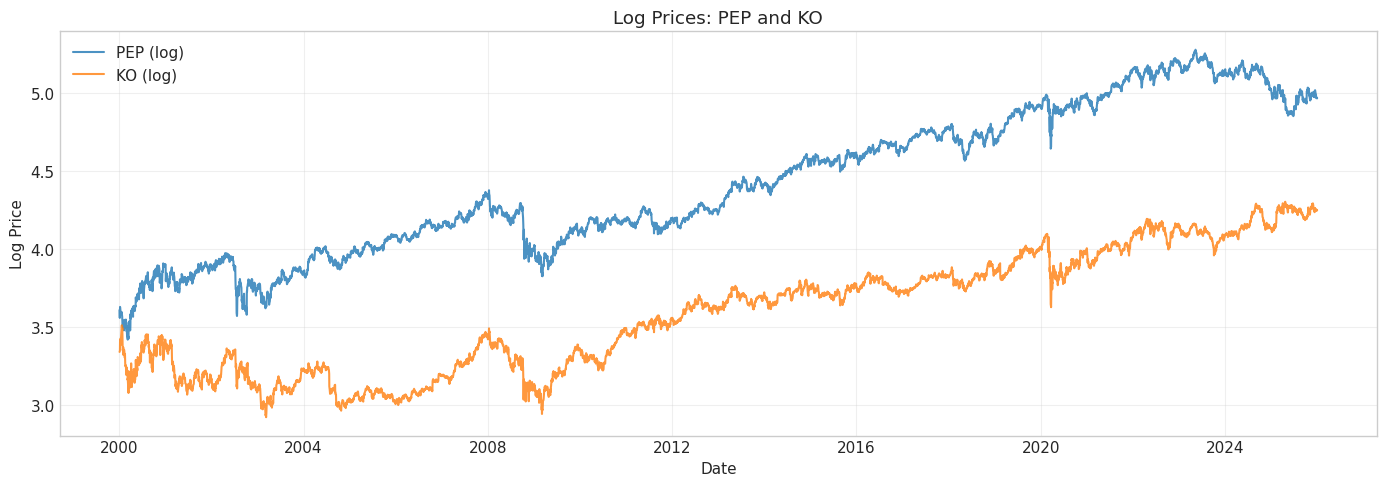

In [10]:
# Plot log prices
fig, ax = plt.subplots(figsize=(14, 5))

log_pep = np.log(pair_data.PA)
log_ko = np.log(pair_data.PB)

ax.plot(log_pep.index, log_pep, label='PEP (log)', alpha=0.8)
ax.plot(log_ko.index, log_ko, label='KO (log)', alpha=0.8)

ax.set_title('Log Prices: PEP and KO')
ax.set_xlabel('Date')
ax.set_ylabel('Log Price')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Spread Computation

In [11]:
from pairs_ssm import compute_spread

# Compute spread with estimated gamma
# compute_spread takes PairData directly and uses log prices by default
spread_data = compute_spread(pair_data, use_log=True)

print(f"Hedge ratio (gamma): {spread_data.gamma:.6f}")
print(f"Spread mean: {spread_data.spread.mean():.6f}")
print(f"Spread std: {spread_data.spread.std():.6f}")

Hedge ratio (gamma): 1.147599
Spread mean: 0.304178
Spread std: 0.162461


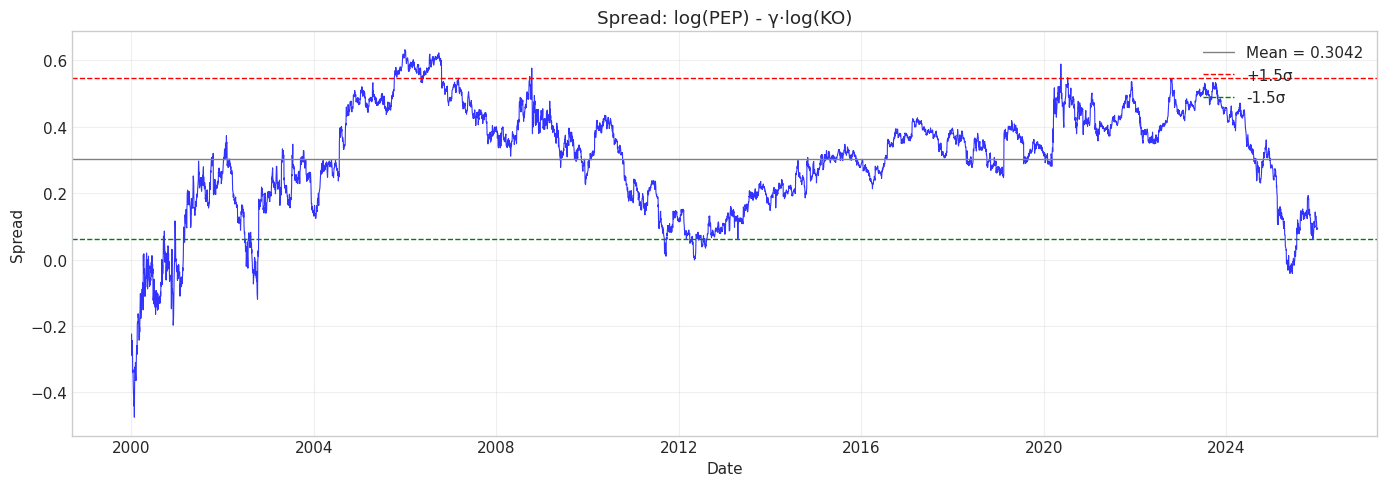

In [12]:
# Plot spread
fig, ax = plt.subplots(figsize=(14, 5))

spread = spread_data.spread
mu_s = spread.mean()
std_s = spread.std()

ax.plot(spread.index, spread, 'b-', linewidth=0.8, alpha=0.8)
ax.axhline(mu_s, color='gray', linestyle='-', linewidth=1, label=f'Mean = {mu_s:.4f}')
ax.axhline(mu_s + 1.5*std_s, color='r', linestyle='--', linewidth=1, label=f'+1.5σ')
ax.axhline(mu_s - 1.5*std_s, color='g', linestyle='--', linewidth=1, label=f'-1.5σ')

ax.set_title('Spread: log(PEP) - γ·log(KO)')
ax.set_xlabel('Date')
ax.set_ylabel('Spread')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Model Estimation

In [13]:
from pairs_ssm import fit_model, compare_models

# Compare Model I and Model II
comparison = compare_models(spread_data.spread, models=["model_I", "model_II"])
print("\nModel Comparison:")
print(comparison)


MODEL COMPARISON
   Model       LogLik           AIC           BIC  theta0   theta1        q            r  AIC_rank  BIC_rank
 model_I 19388.966706 -38769.933412 -38742.791254 0.00115 0.996379 0.000155 2.912838e-07       1.0       1.0
model_II 19388.966706 -38767.933412 -38734.005714 0.00115 0.996379 0.000155 2.912816e-07       2.0       2.0

Best by AIC: model_I
Best by BIC: model_I

Model Comparison:
      Model        LogLik           AIC           BIC   theta0    theta1  \
0   model_I  19388.966706 -38769.933412 -38742.791254  0.00115  0.996379   
1  model_II  19388.966706 -38767.933412 -38734.005714  0.00115  0.996379   

          q             r  AIC_rank  BIC_rank  
0  0.000155  2.912838e-07       1.0       1.0  
1  0.000155  2.912816e-07       2.0       2.0  


In [14]:
# Fit Model II (heteroscedastic)
result = fit_model(spread_data.spread, model_type="model_II")

# fit_model returns a FilterResult object directly
params = result.params

print("\nEstimated Parameters (Model II):")
print(f"  θ₀ (intercept) = {params.theta0:.6f}")
print(f"  θ₁ (AR coef)   = {params.theta1:.6f}")
print(f"  θ₂ (nonlinear) = {params.theta2:.6f}")
print(f"  q_base (state) = {params.q_base:.6e}")
print(f"  q_het          = {params.q_het:.6e}")
print(f"  r (obs noise)  = {params.r:.6e}")
print(f"\nDerived quantities:")
print(f"  Long-run mean C = {params.long_run_mean:.6f}")
print(f"  Long-run std σ  = {params.long_run_std:.6f}")
print(f"\nFit quality:")
print(f"  Log-likelihood  = {result.loglik:.2f}")
print(f"  AIC             = {result.aic:.2f}")
print(f"  BIC             = {result.bic:.2f}")


Estimated Parameters (Model II):
  θ₀ (intercept) = 0.001150
  θ₁ (AR coef)   = 0.996379
  θ₂ (nonlinear) = 0.000000
  q_base (state) = 1.548811e-04
  q_het          = 0.000000e+00
  r (obs noise)  = 2.912816e-07

Derived quantities:
  Long-run mean C = 0.317585
  Long-run std σ  = 0.146380

Fit quality:
  Log-likelihood  = 19388.97
  AIC             = -38767.93
  BIC             = -38734.01


## 4. Kalman Filtering

In [15]:
# Get filtered estimates from the FilterResult
x_filt = result.x_filt.values
P_filt = result.P_filt.values

# Create filtered series
filtered = pd.Series(x_filt, index=spread_data.spread.index)
observed = spread_data.spread

print(f"Observed spread std: {observed.std():.6f}")
print(f"Filtered spread std: {filtered.std():.6f}")
print(f"Noise reduction: {(1 - filtered.std()/observed.std())*100:.1f}%")

Observed spread std: 0.162461
Filtered spread std: 0.162460
Noise reduction: 0.0%


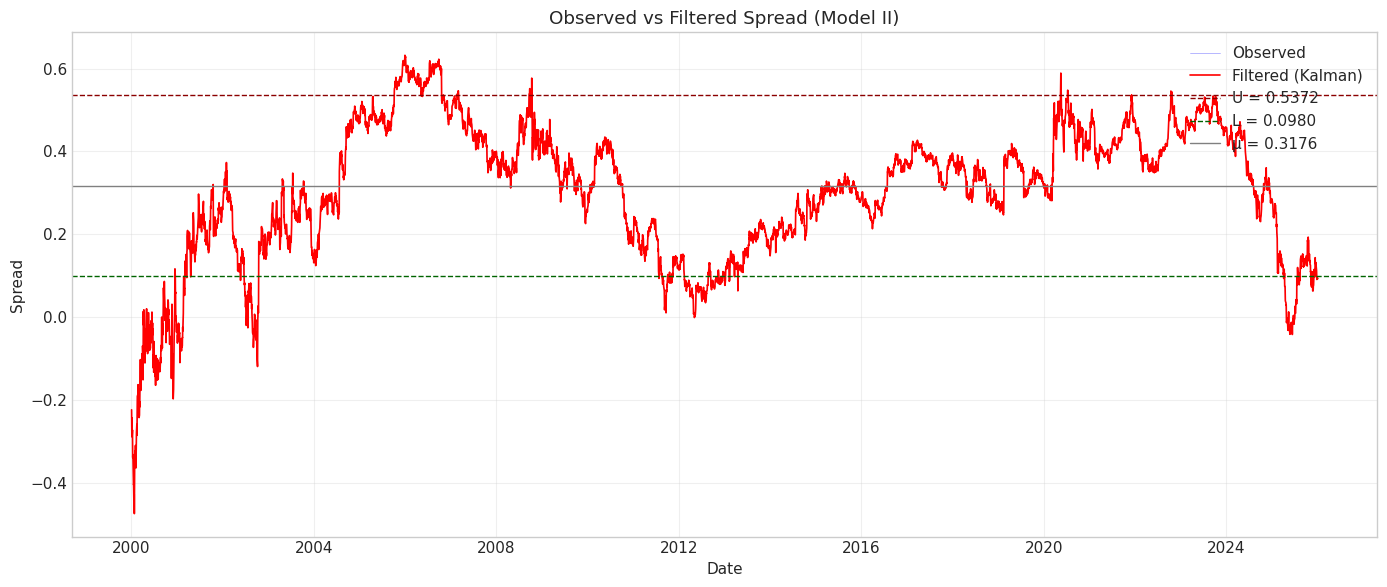

In [16]:
# Plot filtered vs observed
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(observed.index, observed.values, 'b-', alpha=0.4, linewidth=0.5, label='Observed')
ax.plot(filtered.index, filtered.values, 'r-', linewidth=1.2, label='Filtered (Kalman)')

# Thresholds using long-run mean and std
mu = params.long_run_mean
sigma = params.long_run_std
U = mu + 1.5 * sigma
L = mu - 1.5 * sigma

ax.axhline(U, color='darkred', linestyle='--', linewidth=1, label=f'U = {U:.4f}')
ax.axhline(L, color='darkgreen', linestyle='--', linewidth=1, label=f'L = {L:.4f}')
ax.axhline(mu, color='gray', linestyle='-', linewidth=1, label=f'μ = {mu:.4f}')

ax.set_title('Observed vs Filtered Spread (Model II)')
ax.set_xlabel('Date')
ax.set_ylabel('Spread')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Trading Strategies & Backtesting

In [17]:
from pairs_ssm import BacktestEngine

# Create backtest engine - use log prices
log_pep = np.log(pair_data.PA)
log_ko = np.log(pair_data.PB)

engine = BacktestEngine(log_pep, log_ko)
engine.fit("model_II", verbose=False)

# Run backtests for all strategies
results = {}
for strategy in ["A", "B", "C"]:
    bt = engine.backtest(strategy=strategy, n_std=1.5, cost_bp=20)
    results[strategy] = {
        "total_return": bt.total_return(),
        "sharpe": bt.sharpe_ratio(),
        "max_drawdown": bt.max_drawdown(),
        "n_trades": bt.n_trades,
    }

# Display results
df_results = pd.DataFrame(results).T
print("\nStrategy Comparison (Model II, 1.5σ thresholds, 20bp costs):")
print(df_results.round(4))


Strategy Comparison (Model II, 1.5σ thresholds, 20bp costs):
   total_return  sharpe  max_drawdown  n_trades
A        1.6410  0.3819        0.2845      13.0
B        1.7701  0.3911        0.4927       5.0
C        0.2594  0.0898        0.3608      82.0


In [18]:
# Run best strategy with detailed output
bt_result = engine.backtest(strategy="C", n_std=1.5, cost_bp=20)

print(f"\nStrategy C Performance:")
print(f"  Total Return: {bt_result.total_return():.4f}")
print(f"  Annualized Return: {bt_result.annualized_return():.4f}")
print(f"  Sharpe Ratio: {bt_result.sharpe_ratio():.2f}")
print(f"  Max Drawdown: {bt_result.max_drawdown():.4f}")
print(f"  Calmar Ratio: {bt_result.calmar_ratio():.2f}")
print(f"  Number of Trades: {bt_result.n_trades}")


Strategy C Performance:
  Total Return: 0.2594
  Annualized Return: 0.0100
  Sharpe Ratio: 0.09
  Max Drawdown: 0.3608
  Calmar Ratio: 0.03
  Number of Trades: 82


## 6. Results Visualization

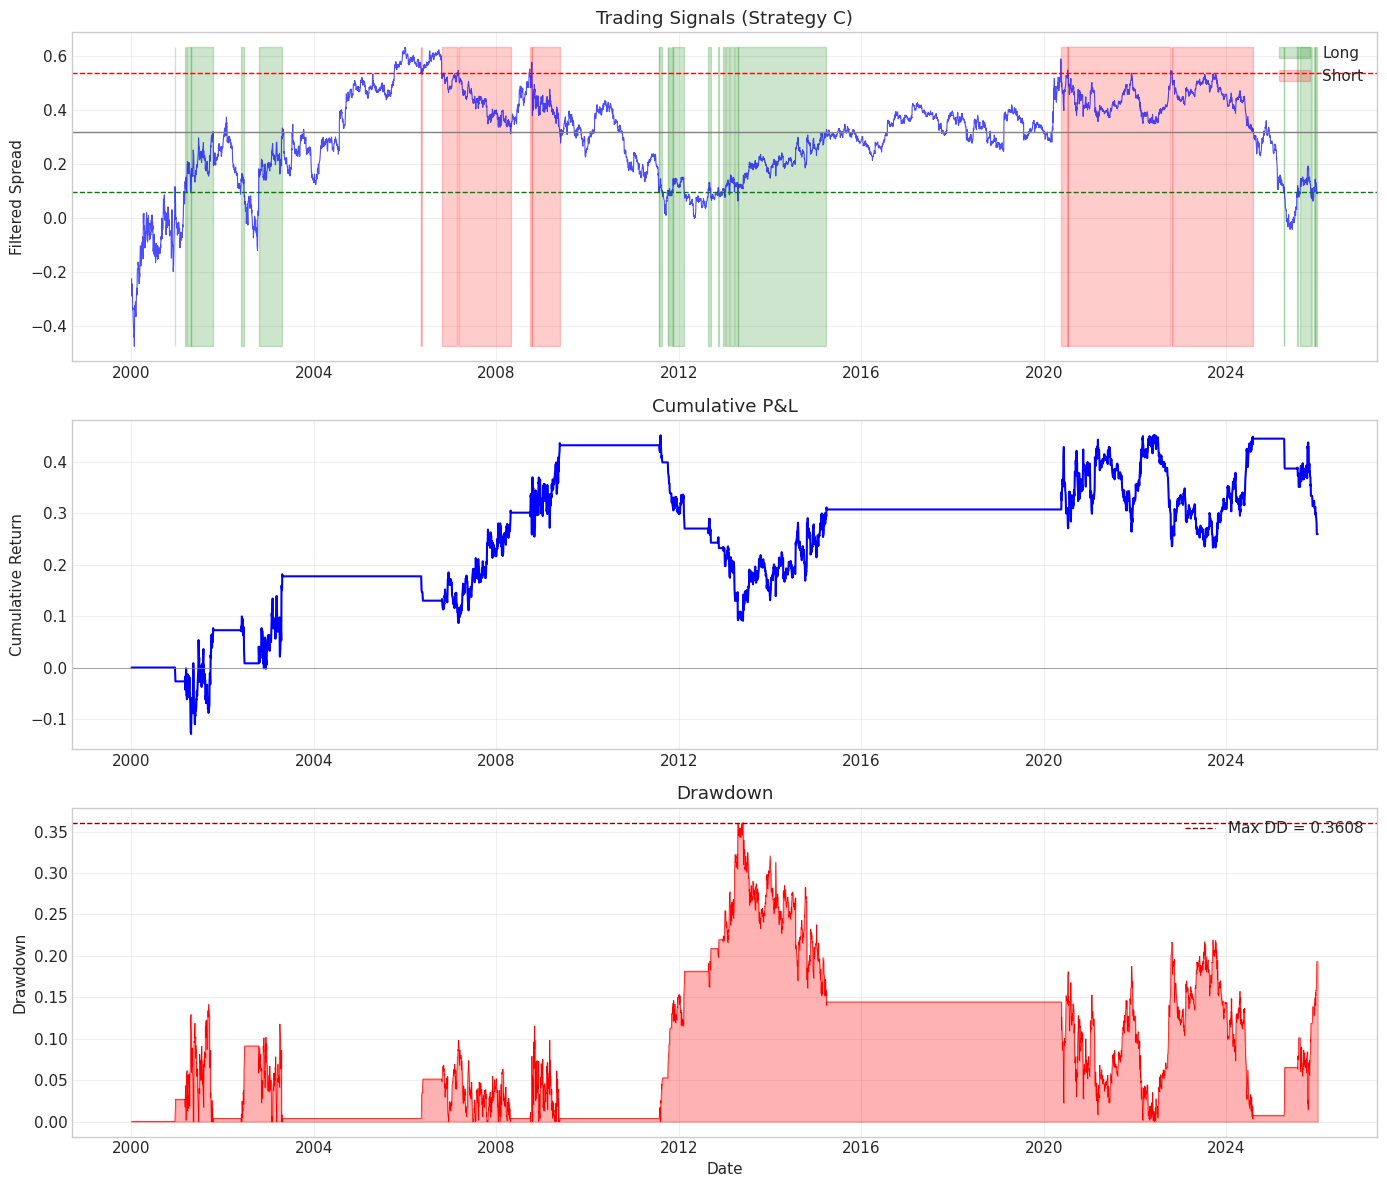

In [19]:
# Multi-panel summary plot
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Panel 1: Spread with signals
ax1 = axes[0]
ax1.plot(filtered.index, filtered.values, 'b-', linewidth=0.8, alpha=0.7)
ax1.axhline(U, color='r', linestyle='--', linewidth=1)
ax1.axhline(L, color='g', linestyle='--', linewidth=1)
ax1.axhline(mu, color='gray', linestyle='-', linewidth=1)

# Get signals from the engine
signals = engine.generate_signals(strategy="C", n_std=1.5)
long_mask = signals == 1
short_mask = signals == -1

ax1.fill_between(filtered.index, filtered.min(), filtered.max(), 
                 where=long_mask, alpha=0.2, color='green', label='Long')
ax1.fill_between(filtered.index, filtered.min(), filtered.max(), 
                 where=short_mask, alpha=0.2, color='red', label='Short')

ax1.set_title('Trading Signals (Strategy C)')
ax1.set_ylabel('Filtered Spread')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Panel 2: Cumulative P&L
ax2 = axes[1]
cum_pnl = bt_result.cumulative_pnl
ax2.plot(cum_pnl.index, cum_pnl.values, 'b-', linewidth=1.5)
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax2.set_title('Cumulative P&L')
ax2.set_ylabel('Cumulative Return')
ax2.grid(True, alpha=0.3)

# Panel 3: Drawdown
ax3 = axes[2]
running_max = cum_pnl.cummax()
drawdown = running_max - cum_pnl

ax3.fill_between(drawdown.index, 0, drawdown.values, color='red', alpha=0.3)
ax3.plot(drawdown.index, drawdown.values, 'r-', linewidth=0.5)
ax3.axhline(drawdown.max(), color='darkred', linestyle='--', linewidth=1, 
            label=f'Max DD = {drawdown.max():.4f}')

ax3.set_title('Drawdown')
ax3.set_xlabel('Date')
ax3.set_ylabel('Drawdown')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary

This notebook demonstrated:

1. **Data Loading**: Loaded PEP-KO pair from Excel
2. **Spread Computation**: Estimated hedge ratio γ via OLS regression
3. **Model Estimation**: Fitted Model I (linear) and Model II (heteroscedastic) via MLE
4. **Kalman Filtering**: Applied filter to extract true spread from noisy observations
5. **Trading Strategies**: Implemented Strategies A, B, C from Zhang (2021)
6. **Backtesting**: Computed performance metrics with transaction costs

### Key Findings
- Model II (heteroscedastic) typically provides better fit (lower AIC/BIC)
- Strategy C (re-entry with stop-loss) is the recommended approach
- Filtered spread provides smoother signals than raw spread
- 1.5σ thresholds balance trade frequency and profitability